In [1]:
import numpy as numpy
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv2
import joblib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.spatial.distance import cosine
from BPutils import *
from tqdm.notebook import tqdm
import os
from sklearn.metrics import top_k_accuracy_score, accuracy_score,\
    mean_squared_error,f1_score, confusion_matrix, ConfusionMatrixDisplay #, plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import LogNorm
from confusion_matrix_pretty_print import *
tf.config.list_physical_devices('GPU')

/tmp/ipykernel_342803/255897883.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-10 12:08:01.397790: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 12:08:01.429339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 12:08:01.429370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

[]

In [2]:
# filename to load
fileName = "mobilenet_combined" # "mobilenet_aff_nir-aff-16_unfrozen_lrs"
# Test on custom image test set instead of AffectNet-NIR
test_on_custom_test_set = True

##################
if test_on_custom_test_set:
    subdir_fp_column_name = "adjusted_unique_filename"
    annotations_file = "annotations_splits/df_fer_test.csv"
    data_folder = '../data_folder/combined_fer/'
    test_name = fileName + " - combined test set "
    test_name_w_underscores = fileName + "-combined_test_set"
else:
    subdir_fp_column_name = "subDirectory_filePath"
    annotations_file = "annotations_splits/test_affectnet_nir.csv"
    data_folder = '../data_folder/AffectNet-NIR/train_set/'
    test_name = fileName + " - AffectNet NIR Test set"
    test_name_w_underscores = fileName + "-affectnet_test_set"
    affectnet_all_images_as_jpg = True

In [3]:
# Model input dimension and color channels
__IN_DIM = 224
__CHANNELS = 3
# whether to run checkpoint weights with highest val metric or final weights
runBest = True
# Preprocessing to [-1;1] range, all new models use it
rescale_to_11_range = True
# Scaling of sigmoid output in some models to V,A \in [-1;1] range
use_sig_entropy_loss = True
# Use GUI visualized for the predicted annotations
run_data_inspection = 0
__GEN_BATCHSIZE = 1

###################
##  LOAD models
##################

# load json and create model
loaded_model = tf.keras.models.model_from_json( open( ("models/fer/%s.json"%fileName) , 'r') . read() )
# load weights into new model
if (runBest):
    loaded_model.load_weights(("models/fer/%s_CHECKPOINT.hdf5"%fileName))
else:
    loaded_model.load_weights(("models/fer/%s.h5"%fileName))

print("Loaded model from disk")

Loaded model from disk


In [4]:
training_data = pd.read_csv(annotations_file)
if not test_on_custom_test_set:
    ########## ADDED ##########
    if affectnet_all_images_as_jpg:
        training_data[subdir_fp_column_name] = training_data.apply(lambda row: str(row['Unnamed: 0']) + '.' + 'jpg', axis=1)
    else:
        training_data[subdir_fp_column_name] = training_data.apply(lambda row: str(row['Unnamed: 0']) + '.' + str(row['FileType']), axis=1)
    ###########################
    training_data = training_data[training_data.valence != -2]
    
    training_data['FileType'] = training_data[subdir_fp_column_name].apply(lambda x: x.split('.')[-1])
    training_data = training_data[training_data['FileType'] != 'tif']

    # remove 'none' category
    training_data = training_data[training_data.expression != 8]

In [5]:
training_data

,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,...,race,expression,valence,arousal,expression_name,buaa-patient,buaa-image_type,customdb-patient,new_filetype,split
0,90,90,data/BUAA/BUAAVISNIR/34/2.bmp,721,buaa,nir,2.bmp,buaa-34-2.jpg,NaN,NaN,...,mongo,0.0,0.000000,0.000000,Neutral,34.0,neutral,NaN,jpg,test
1,91,91,data/BUAA/BUAAVISNIR/34/22.bmp,739,buaa,nir,22.bmp,buaa-34-22.jpg,NaN,NaN,...,mongo,1.0,0.550000,0.190000,Happy,34.0,affection,NaN,jpg,test
2,92,92,data/BUAA/BUAAVISNIR/34/24.bmp,741,buaa,nir,24.bmp,buaa-34-24.jpg,NaN,NaN,...,mongo,1.0,0.740000,-0.310000,Happy,34.0,affection,NaN,jpg,test
3,93,93,data/BUAA/BUAAVISNIR/34/26.bmp,743,buaa,nir,26.bmp,buaa-34-26.jpg,NaN,NaN,...,mongo,1.0,0.510000,-0.530000,Happy,34.0,affection,NaN,jpg,test
4,94,94,data/BUAA/BUAAVISNIR/34/28.bmp,745,buaa,nir,28.bmp,buaa-34-28.jpg,NaN,NaN,...,mongo,1.0,0.690000,0.140000,Happy,34.0,affection,NaN,jpg,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2336,2336,data/B_OriginalImg/NI/Strong/P079/Sadness/018....,7562,oulucasia,nir,018.jpeg,oulucasia-P079-Sadness-018.jpg,P079,Sadness,...,mongo,2.0,-0.826687,-0.393660,Sad,NaN,NaN,NaN,jpg,test
253,2337,2337,data/B_OriginalImg/NI/Strong/P079/Sadness/004....,7563,oulucasia,nir,004.jpeg,oulucasia-P079-Sadness-004.jpg,P079,Sadness,...,mongo,0.0,0.000000,0.000000,Neutral,NaN,NaN,NaN,jpg,test
254,2338,2338,data/B_OriginalImg/NI/Strong/P079/Surprise/002...,7564,oulucasia,nir,002.jpeg,oulucasia-P079-Surprise-002.jpg,P079,Surprise,...,mongo,0.0,0.000000,0.000000,Neutral,NaN,NaN,NaN,jpg,test
255,2339,2339,data/B_OriginalImg/NI/Strong/P079/Surprise/015...,7565,oulucasia,nir,015.jpeg,oulucasia-P079-Surprise-015.jpg,P079,Surprise,...,mongo,3.0,0.285114,0.807823,Surprise,NaN,NaN,NaN,jpg,test


In [6]:
# DROP NONEXISTING FILES

# Assuming training_data is your DataFrame
non_existent_files = []
non_existent_files_fps = []

for index, row in training_data.iterrows():
    file_path = data_folder + row[subdir_fp_column_name]
    if not os.path.isfile(file_path):
        non_existent_files.append(index)
        non_existent_files_fps.append(file_path)

# Remove non-existent files from DataFrame
training_data = training_data.drop(non_existent_files)

print("Dropped test files:", len(non_existent_files), "|", "remained test set:", len(training_data.index))

Dropped test files: 0 | remained test set: 257


In [7]:
if (rescale_to_11_range):
    test_datagen=ImageDataGenerator(
        rescale=2./255.,
        samplewise_center = True
        )
else:
    test_datagen=ImageDataGenerator()

In [8]:
if(test_on_custom_test_set):
    if(__CHANNELS == 1):
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,
        x_col=subdir_fp_column_name,#"filename",
        color_mode= "grayscale",
        batch_size=1,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,#True,
        target_size=(__IN_DIM,__IN_DIM))
    else:
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,
        x_col=subdir_fp_column_name,#"filename",
        #color_mode= "grayscale",
        batch_size=1,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,#True,
        target_size=(__IN_DIM,__IN_DIM))
else:
    if(__CHANNELS == 1):
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,#"../data_folder/AffectNet-NIR/train_set/",
        x_col=subdir_fp_column_name,#"subDirectory_filePath",
        color_mode= "grayscale",
        batch_size=__GEN_BATCHSIZE,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,
        target_size=(__IN_DIM,__IN_DIM))
    else:
        test_generator=test_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=data_folder,#"../data_folder/AffectNet-NIR/train_set/",
        x_col=subdir_fp_column_name,#"subDirectory_filePath",
        #color_mode= "grayscale",
        batch_size=__GEN_BATCHSIZE,
        #seed=42,
        shuffle=False,
        class_mode=None,
        validate_filenames=False,
        target_size=(__IN_DIM,__IN_DIM))

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

predictions = loaded_model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1, workers=8)

if(use_sig_entropy_loss):
    predictions[1] = (2 *( predictions[1] - 0.5))

Found 257 non-validated image filenames.
257/257 [==============================] - 4s 15ms/step


In [9]:
training_data['valence_hat']=predictions[1].T[0]
training_data['arousal_hat']=predictions[1].T[1]
training_data['expression_hat']=np.argmax(predictions[0].T,axis=0)
for i in range(0,8):
    training_data["%s_hat"%e_eval[i]] = predictions[0].T[i]

In [10]:
training_data.head(1)

,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,...,arousal_hat,expression_hat,Neutral_hat,Happy_hat,Sad_hat,Surprise_hat,Fear_hat,Disgust_hat,Anger_hat,Contempt_hat
0,90,90,data/BUAA/BUAAVISNIR/34/2.bmp,721,buaa,nir,2.bmp,buaa-34-2.jpg,NaN,NaN,...,0.332193,1,0.18373,0.221705,0.07738,0.081565,0.02478,0.086034,0.133774,0.191032


In [11]:
y_true = np.array(training_data['expression'].values.tolist())
y_pred = np.array(training_data['expression_hat'].values.tolist())


m_top1 = accuracy_score(y_true, y_pred)
m_top2 = top_k_accuracy_score(y_true, predictions[0], k=2)
m_top3 = top_k_accuracy_score(y_true, predictions[0], k=3)
m_f1 = f1_score(y_true, y_pred, average='macro')
m_val_rmse = mean_squared_error(training_data.valence, training_data.valence_hat, squared = False)
m_aro_rmse = mean_squared_error(training_data.arousal, training_data.arousal_hat, squared = False)
m_val_sagr = SAGR(training_data.valence, training_data.valence_hat)
m_aro_sagr = SAGR(training_data.arousal, training_data.arousal_hat)
m_val_ccc = CCC(training_data.valence, training_data.valence_hat)
m_aro_ccc = CCC(training_data.arousal, training_data.arousal_hat)

print( "TOP-1 ACCURACY = %.5f" % accuracy_score(y_true, y_pred))
print( "TOP-2 ACCURACY = %.5f" % top_k_accuracy_score(y_true, predictions[0], k=2))
print( "TOP-3 ACCURACY = %.5f" % top_k_accuracy_score(y_true, predictions[0], k=3))
print( "F1 = %.5f" % f1_score(y_true, y_pred, average='macro'))
print("----------------------------------------")
print("Metrics from EmoNet")
print( "ACC = %.5f" % ACC(y_true, y_pred))

print("\n\n\n\n")

#################################
# MODEL PREDICTION EVAL METRICS #
#################################
# RMSE, CORR, SAGR, CCC
print("VALENCE RMSE: %f" % mean_squared_error(training_data.valence, training_data.valence_hat, squared = False))
print("AROUSAL RMSE: %f" % mean_squared_error(training_data.arousal, training_data.arousal_hat, squared = False))
print("----------------------------------------")
print("Metrics from EmoNet")
print( "VAL SAGR = %.5f" % SAGR(training_data.valence, training_data.valence_hat))
print( "ARO SAGR = %.5f" % SAGR(training_data.arousal, training_data.arousal_hat))
print( "VAL CCC = %.5f" % CCC(training_data.valence, training_data.valence_hat))
print( "ARO CCC = %.5f" % CCC(training_data.arousal, training_data.arousal_hat))

TOP-1 ACCURACY = 0.53696
TOP-2 ACCURACY = 0.71595
TOP-3 ACCURACY = 0.84047
F1 = 0.48022
----------------------------------------
Metrics from EmoNet
ACC = 0.53696





VALENCE RMSE: 0.381221
AROUSAL RMSE: 0.400925
----------------------------------------
Metrics from EmoNet
VAL SAGR = 0.57198
ARO SAGR = 0.59533
VAL CCC = 0.40723
ARO CCC = 0.15569


<Axes: >

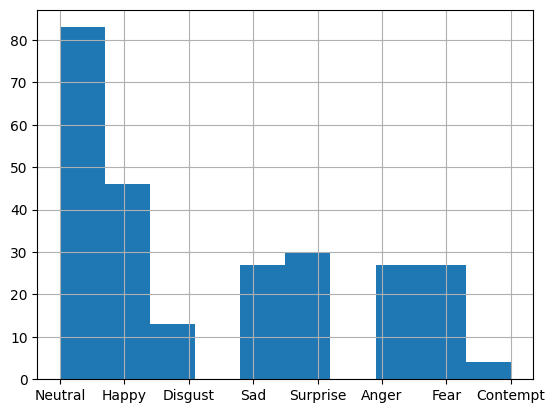

In [12]:
training_data.expression_name.hist()

<!--* TOP-1 ACCURACY = 0.60304
* TOP-2 ACCURACY = 0.78952
* TOP-3 ACCURACY = 0.88564
* F1 = 0.43943

Metrics from EmoNet
* ACC = 0.60304


***


* VALENCE RMSE: 0.405555
* AROUSAL RMSE: 0.313686

Metrics from EmoNet
* VAL SAGR = 0.72699
* ARO SAGR = 0.64172
* VAL CCC = 0.64313
* ARO CCC = 0.33769 -->
pass

<!--**PERFORMANCE OF MOBILENET ON VIS AFFECTNET** - AffectNet Test set

Consider testing/training with class weights

***
* TOP-1 ACCURACY = 0.62

* TOP-2 ACCURACY = 0.77500
* TOP-3 ACCURACY = 0.86875
* F1 = 0.47

*Metrics from EmoNet*
* ACC = 0.60625

***

* VALENCE RMSE: 0.285
* AROUSAL RMSE: 0.236

*Metrics from EmoNet*
* VAL SAGR = 0.74375
* ARO SAGR = 0.65000
* VAL CCC = 0.822
* ARO CCC = 0.598

***

**PERFORMANCE OF MOBILENET ON VIS AFFECTNET** - Custom 160 Test set

Consider testing/training with class weights

***
* TOP-1 ACCURACY = 0.60625
* TOP-2 ACCURACY = 0.77500
* TOP-3 ACCURACY = 0.86875
* F1 = 0.54995

*Metrics from EmoNet*
* ACC = 0.60625

***

* VALENCE RMSE: 0.339658
* AROUSAL RMSE: 0.399160

*Metrics from EmoNet*
* VAL SAGR = 0.74375
* ARO SAGR = 0.65000
* VAL CCC = 0.66519
* ARO CCC = 0.47729

***

**PERFORMANCE OF DDAMFN MODEL ON VIS AFFECTNET - SOTA**

Consider testing/training with class weights

***

* TOP-1 ACCURACY = 0.6475

***

**PERFORMANCE OF EfficientNet-B0 MODEL ON NIR AFFECTNET** - Chen et al. (2022)

***

* VAL RMSE = 0.447
* ARO RMSE = 0.373
* VAL CCC = 0.527
* ARO CCC = 0.426

In [13]:
############################
## 200-fold down-sampled skew-normalized test
############################
sampleSize = 4 if test_on_custom_test_set else 500
acc_acc = []
f1_acc = []
for cycle in range(1,201):
    frames = []
    for i in range(0,8):
        frames.append(training_data[training_data.expression == i].sample(n=sampleSize, random_state=cycle).copy())
    tmp_downsampled_df = pd.concat(frames)

    y_true = np.array(tmp_downsampled_df['expression'].values.tolist())
    y_pred = np.array(tmp_downsampled_df['expression_hat'].values.tolist())

    acc_acc.append(ACC(y_true, y_pred))
    f1_acc.append(f1_score(y_true, y_pred, average='macro'))

m_200fold_top1 = np.mean(acc_acc)
m_200fold_f1 = np.mean(f1_acc)
    
print( "TOP-1 mean 200fold ACCURACY = %.5f" % np.mean(acc_acc))
print( "F-1 mean 200fold score = %.5f" % np.mean(f1_acc))

TOP-1 mean 200fold ACCURACY = 0.49297
F-1 mean 200fold score = 0.48400


**PERFORMANCE OF MOBILENET ON VIS AFFECTNET** - Custom 160 Test set

200-fold down-sampled skew-normalized test

***

* TOP-1 mean 200fold ACCURACY = 0.55425
* F-1 mean 200fold score = 0.53701

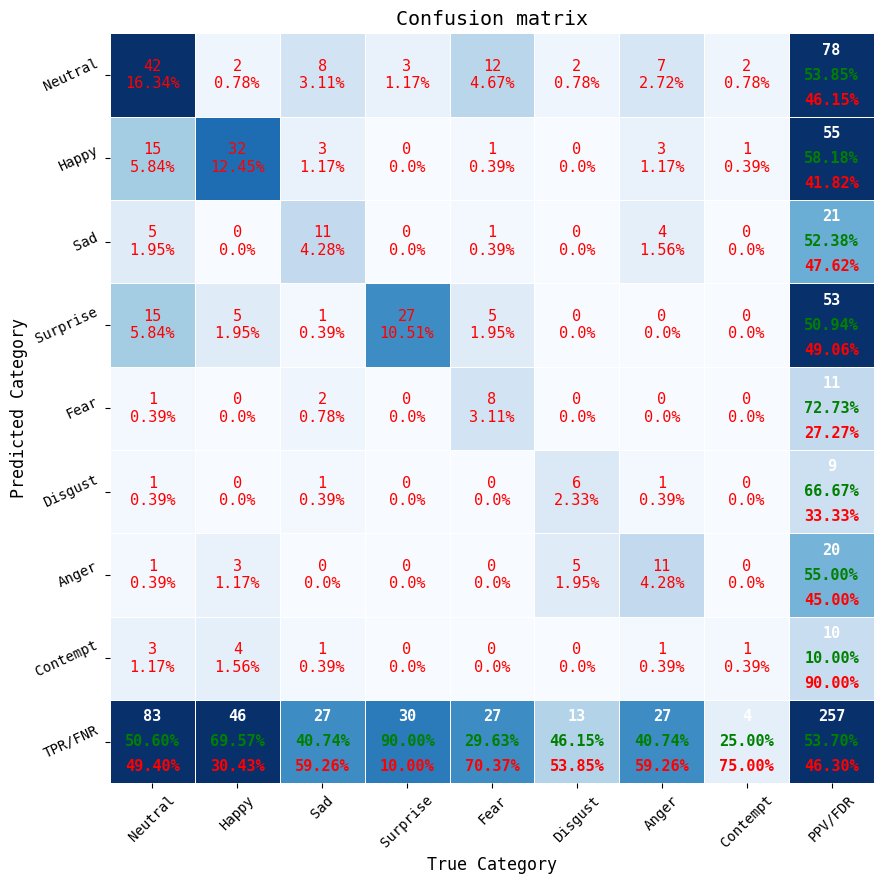

In [14]:
#################################
# FEW  MODEL CONFUSION MATRICES #
#################################
font = {
'family': 'monospace',
'size': 12
}
matplotlib.rc('font', **font)
y_true = training_data['expression'].values.tolist()
y_pred = training_data['expression_hat'].values.tolist()
mat = confusion_matrix(y_true, y_pred)

if(False):
    CMD = ConfusionMatrixDisplay(confusion_matrix=mat,display_labels=e_eval_8, )
    fig, ax = plt.subplots(figsize=(10,10))
    CMD.plot(ax=ax)

elif(False):
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(mat, annot=True, xticklabels=e_eval[:-1], yticklabels=e_eval[:-1], fmt=".0f", robust=True)#, norm=LogNorm())
    #ax.set(xlabel='Label', ylabel='Prediction', title="confusion matrix")
    plt.show()

elif(True):
    #
    # https://github.com/wcipriano/pretty-print-confusion-matrix
    #
    fig = plot_confusion_matrix_from_data(y_true, y_pred, columns=e_eval[:-1], cmap="Blues")
    fig.savefig("tests/"+test_name_w_underscores+"-conf_matrix.png", format="png", dpi=500)
else:
    display(mat)
    classes = e_eval_8
    accuracies = mat/mat.sum(1)
    fig, ax = plt.subplots(figsize=(10,8))
    cb = ax.imshow(accuracies, cmap='Greens')
    plt.xticks(range(len(classes)), classes,rotation=0)
    plt.yticks(range(len(classes)), classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            color='green' if accuracies[i,j] < 0.5 else 'white'
            ax.annotate(f'{mat[i,j]}', (i,j), 
                        color=color, va='center', ha='center')

    plt.colorbar(cb, ax=ax)
    plt.show()

N-RMSE: 0.333831 0.342015 0.337923


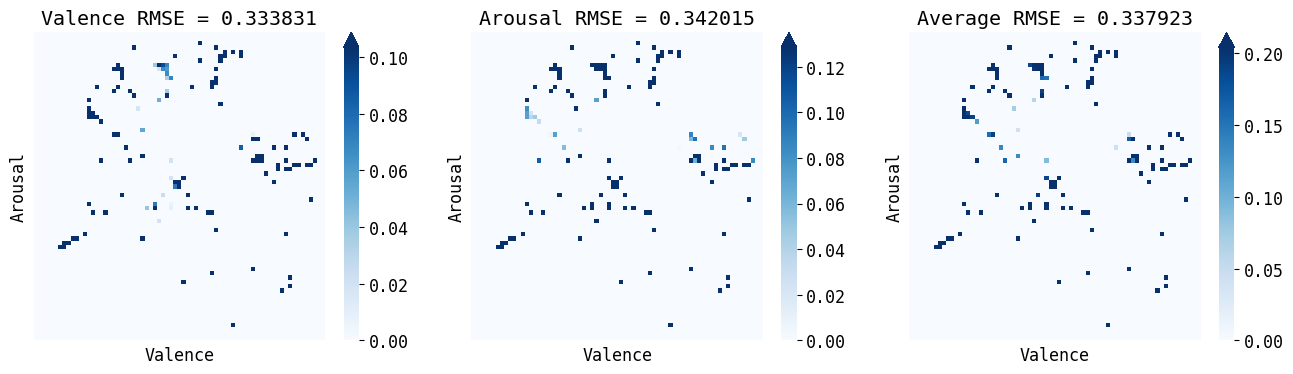

In [18]:
def rmse_boxes(df, _num_boxes=12, show_avg_rmse=False, annot=False):
    # calc boxes and init accumulators
    t = np.linspace(-1,1,_num_boxes+1)
    accumulator_val = []
    accumulator_aro = []

    # iterate over intervals in 2d
    for val_int in [(x,y) for x,y in zip(t[:-1], t[1:])]:
        inner_acc_val = []
        inner_acc_aro = []
        for aro_int in [(x,y) for x,y in zip(t[:-1], t[1:])]:
            
            # calculate valence and arousal rmse for points in 2d interval
            #display((val_int,aro_int))
            tmp = df[ (df.valence >= val_int[0]) & (df.valence <= val_int[1]) \
                    & (df.arousal >= aro_int[0]) & (df.arousal <= aro_int[1]) ]
            if( len(tmp.index) != 0 ):
                inner_acc_val.append(mean_squared_error(tmp.valence, tmp.valence_hat, squared = False))
                inner_acc_aro.append(mean_squared_error(tmp.arousal, tmp.arousal_hat, squared = False))
            else:
                inner_acc_val.append(0)
                inner_acc_aro.append(0)

        accumulator_val.append(inner_acc_val)
        accumulator_aro.append(inner_acc_aro)


    #display((accumulator_val, accumulator_aro))
    accumulator_val = np.array(accumulator_val)
    accumulator_aro = np.array(accumulator_aro)
    
    accumulator_val = np.rot90(accumulator_val, 1, (0, 1))
    accumulator_aro = np.rot90(accumulator_aro, 1, (0, 1))
    

    fig = plt.figure(figsize=(16,4))
    plt.subplot(131) if show_avg_rmse else plt.subplot(121)
    plt.title("Valence RMSE = %f" % np.mean(accumulator_val[accumulator_val != 0]))
    sns.heatmap(accumulator_val, cmap="Blues", robust=True, annot=annot, fmt=".2f",cbar_kws={'extend':'max'})
    plt.xlabel("Valence")
    plt.ylabel("Arousal")
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.subplot(132) if show_avg_rmse else plt.subplot(122)
    plt.title("Arousal RMSE = %f" % np.mean(accumulator_aro[accumulator_aro != 0]))
    sns.heatmap(accumulator_aro, cmap="Blues", robust=True, annot=annot, fmt=".2f",cbar_kws={'extend':'max'})
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.xlabel("Valence")
    plt.ylabel("Arousal")
    if (show_avg_rmse):
        plt.subplot(133)
        plt.title("Average RMSE = %f" % np.mean((accumulator_val + accumulator_aro)[(accumulator_val + accumulator_aro) != 0] /2))
        sns.heatmap((accumulator_val + accumulator_aro)/2, cmap="Blues", robust=True, annot=annot, fmt=".2f",
                   cbar_kws={'extend':'max'})
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        plt.xlabel("Valence")
        plt.ylabel("Arousal")
    print("N-RMSE: %f %f %f"%(np.mean(accumulator_val[accumulator_val != 0]),np.mean(accumulator_aro[accumulator_aro != 0]),np.mean((accumulator_val + accumulator_aro)[(accumulator_val + accumulator_aro) != 0] /2)))
    return fig
fig = rmse_boxes(training_data, 71, show_avg_rmse=True, annot=False)
fig.savefig("tests/"+test_name_w_underscores+"-rmse_boxes.png", dpi=500, format="png")

**PERFORMANCE OF MOBILENET ON VIS AFFECTNET**

***

* N-RMSE: 0.273485 0.321181 0.297333

In [ ]:
#################################################################################
# GUI Visualizer for inspection of individual samples and their classifications #
#################################################################################
from PIL import Image

def inspect_data_hybrid(data, iterations):
    for _row_ in range(0,iterations):
        # Image selection
        test_col = data[_row_:_row_+1]
        data_dir = data_folder
        impath = data_dir  + [x for x in test_col[subdir_fp_column_name]][0],

        impath = impath[0]
        print(impath)
        # Fetching image data
        img = cv2.imread(str(impath))
        imS = cv2.resize(img, (512, 512))

        imPREDICT = cv2.resize(cv2.cvtColor(imS, cv2.COLOR_BGR2GRAY),(__IN_DIM,__IN_DIM)) if __CHANNELS == 1 else cv2.resize(cv2.cvtColor(imS, cv2.COLOR_BGR2RGB),(__IN_DIM,__IN_DIM))#cv2.cvtColor(imS, cv2.COLOR_BGR2RGB)
        if(rescale_to_11_range):
            imPREDICT = imPREDICT / 127.5
            imPREDICT = imPREDICT - 1

        # Predictions
        predictions = loaded_model.predict(imPREDICT.reshape(1,__IN_DIM,__IN_DIM,__CHANNELS))
        predictedEmotion = int(np.argmax(predictions[0]))

        if(use_sig_entropy_loss):
            predictions[1][0] = (2 *( predictions[1][0] - 0.5))

        # Drawing
        imS = cv2.putText(imS, "Valence: %f | Arousal: %f | Category: %d" % \
                      (test_col.valence, test_col.arousal, test_col.expression), \
                      (20,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (25,225,225), 1, cv2.LINE_AA)

        # Pad and pretty print
        imS = cv2.copyMakeBorder(imS, 100,300,50,350,cv2.BORDER_CONSTANT)
        imS = cv2.putText(imS, "Model evaluation:", (20,50), cv2.FONT_HERSHEY_SIMPLEX,
                      1, (25,225,225), 2, cv2.LINE_AA)

        imS = cv2.putText(imS, "Predicted emotion:", (300,650), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (25,225,225), 1, cv2.LINE_AA)
        imS = cv2.putText(imS, "%s" % (e_dict[predictedEmotion]),
                      (450 + getTextSize("%s" % (e_eval[predictedEmotion]), 0.5)[0]//2
                                      ,650), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (25,225,225), 1, cv2.LINE_AA)

        imS = cv2.putText(imS, "Annotated emotion:", (20,650), cv2.FONT_HERSHEY_SIMPLEX,
                      0.5, (25,225,225), 1, cv2.LINE_AA)
        imS = cv2.putText(imS, "%s" % (e_eval[int(test_col.expression.values[0])]),
                      (170 + getTextSize("%s" % (e_eval[int(test_col.expression.values[0])]), 0.5)[0]//2
                                      ,650), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      (25,225,225), 1, cv2.LINE_AA)




        drawVAgraph(imS, 20, 670, 200, test_col.valence.values[0], test_col.arousal.values[0],
                  predict_emotion = False, concat_axis_descriptions = True )

        drawVAgraph(imS, 300, 670, 200, predictions[1][0][0], predictions[1][0][1],
          predict_emotion = False, concat_axis_descriptions = True )



        imS = cv2.putText(imS, "annotation:",
                      (700,25),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (25,225,225), 1, cv2.LINE_AA)
        # imS = cv2.putText(imS, "%s" % (e_eval[test_col.expression.values[0]]),
        #                 (750 - getTextSize("%s" % (e_eval[test_col.expression.values[0]]), 2)[0]//2
        #                     ,60 + getTextSize("%s" % (e_eval[test_col.expression.values[0]]), 2)[1]//2),
        #                 cv2.FONT_HERSHEY_SIMPLEX, 2, (25,225,225), 1, cv2.LINE_AA)
        is_correct = predictedEmotion == test_col.expression.values[0]
        imS = cv2.putText(imS, "%s" % (e_eval[int(test_col.expression.values[0])]),
                      (750 - getTextSize("%s" % (e_eval[int(test_col.expression.values[0])]), 2)[0]//2
                          ,60 + getTextSize("%s" % (e_eval[int(test_col.expression.values[0])]), 2)[1]//2),
                      cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0) if is_correct else (255,0,0), 1, cv2.LINE_AA)

        _offset = 0
        for i in range(0,8):
            imS = cv2.putText(imS, "%s:" % (e_dict[i]), (600
                  ,110+_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (25,225,225), 1, cv2.LINE_AA)
            imS = draw_progress_bar(imS, 600,120+_offset,300,50,predictions[0][0][i])
            _offset += 90


        display(Image.fromarray(imS))


run_data_inspection = 200
if (run_data_inspection > 0):
    inspect_data_hybrid(training_data, run_data_inspection)


### Results

In [ ]:
metrics_fp = "tests/test_metrics.csv"

if not os.path.exists(metrics_fp):
    # Add results not created by me
    df_results = pd.DataFrame({
        "model": [
            'EfficientNet-B0 MODEL ON NIR AFFECTNET - Chen et al. (2022)',
            "DDAMFN MODEL ON VIS AFFECTNET - SOTA",
            "MOBILENET ON VIS AFFECTNET - AffectNet Test set",
            "MOBILENET ON VIS AFFECTNET - Custom160 Test set",
        ],
        "top-1-acc": [None,0.6475,0.62, 0.60625],
        "top-2-acc": [None, None, None, 0.77500],
        "top-3-acc": [None, None, None, 0.86875],
        "f1": [None,None,0.47, 0.54995],
        "val-rmse": [0.447,None,0.285,0.339658],
        "val-ccc": [0.527,None,0.822, 0.66519],
        "val-sagr": [None, None, None, 0.74375],
        "aro-rmse": [0.373,None,0.236, 0.399160],
        "aro-ccc": [0.426,None,0.598,0.47729],
        "aro-sagr": [None, None, None, 0.65000],
        "200fold-top1": [None, None, None,0.55425],
        "200fold-f1": [None, None, None,0.53701]
    })
    
    df_results.to_csv(metrics_fp, index=False)
    
df_results = pd.read_csv(metrics_fp)

new_row = [test_name,
           m_top1, m_top2, m_top3, m_f1, m_val_rmse, m_val_ccc, m_val_sagr,
           m_aro_rmse, m_aro_ccc, m_aro_sagr, m_200fold_top1, m_200fold_f1]

if test_name in df_results.model.tolist():
    index = df_results['model'].where(df_results['model'] == test_name).dropna().index[0]
else:
    index = len(df_results.index)

df_results.loc[index] = new_row
df_results.to_csv(metrics_fp, index=False)

In [ ]:
# Set the display option so whole data is displayed
pd.set_option('display.max_colwidth', None)

In [ ]:
df_results

## Export

In [ ]:
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(loaded_model)

# Save the ONNX model to disk
with open("models/fer/"+fileName+".onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())